In [1]:
import torch
x = torch.rand(5, 3)
print(x)
print(torch.cuda.is_available())

tensor([[0.5491, 0.4465, 0.0142],
        [0.7427, 0.3620, 0.4476],
        [0.7590, 0.7902, 0.5841],
        [0.0437, 0.8524, 0.4796],
        [0.0350, 0.0340, 0.5057]])
True


In [2]:
import os
import random
import seaborn as sns
import scipy
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt

In [3]:
mix = 0.4
num_samples = 30
mixture_weight = [mix, 1.-mix]
mixture_components = [scipy.stats.norm(loc=-1, scale=0.1), scipy.stats.norm(loc=1, scale=0.5)]
np.random.choice(range(0, len(mixture_weight)), 
                               p=mixture_weight, size=num_samples)

array([0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1])

In [3]:
mix = 0.4
num_samples = 30
mixture_weight = torch.tensor([mix, 1.-mix], dtype=torch.float)
mixture_components = [scipy.stats.norm(loc=-1, scale=0.1), scipy.stats.norm(loc=1, scale=0.5)]
torch.multinomial(input=mixture_weight, num_samples=num_samples, replacement=True)

tensor([1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
        0, 1, 1, 0, 1, 0])

In [6]:
# We implement our own very simple mixture, relying on scipy for the mixture
# components.

class SimpleGaussianMixture(object):

  def __init__(self, mixture_weights, mixture_components):
    self.mixture_weights = mixture_weights
    self.mixture_components = mixture_components

  def sample(self, num_samples, sample_seed=None):
    if(sample_seed):
        np.random.seed(seed=sample_seed)
        torch.random.manual_seed(seed=sample_seed)
    # First sample from the mixture
    mixture_choices = torch.multinomial(input=self.mixture_weights, num_samples=num_samples, replacement=True)
    # And then sample from the chosen mixture
    samples = torch.from_numpy(np.array(
          [self.mixture_components[mixture_choice].rvs(size=1)
           for mixture_choice in mixture_choices]))
    return mixture_choices, samples

  def pdf(self, x):
    value = 0.
    for index, weight in enumerate(self.mixture_weights):
      # Assuming using scipy distributions for components
      value += weight * self.mixture_components[index].pdf(x)
    return value

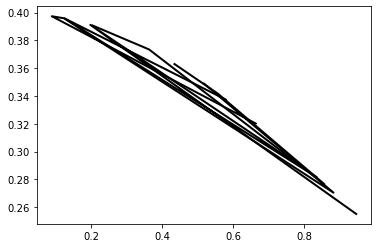

In [4]:
from scipy.stats import norm
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
r = norm.rvs(size=1000)
rv = norm()
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

In [7]:
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')
ax.hist(r, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()

In [39]:
mix = 0.4
mixture_weight = torch.tensor([mix, 1.-mix], dtype=torch.float)
mixture_components = [scipy.stats.norm(loc=-1, scale=0.1), scipy.stats.norm(loc=1, scale=0.5)]
mixture_train = SimpleGaussianMixture(mixture_weight, mixture_components)
mixture_val = SimpleGaussianMixture(mixture_weight, mixture_components)

In [11]:
mixture.pdf([10, 1])
for i in range(101,1000):
    train_samples = mixture.sample(100000)
    torch.save(train_samples,'test_gmm_data/train_gmm_'+str(i)+'.pt')
    test_samples = mixture.sample(20000)
    torch.save(test_samples,'train_gmm_data/test_gmm_'+str(i)+'.pt')

In [99]:
sample_class , sample = mixture.sample(num_samples=5) 
print(sample_class)
print(sample)
#model(sample)
#RuntimeError: expected scalar type Double but found Float
#model(sample.float())
#RuntimeError: expected scalar type Double but found Float
#model(sample.double())
#RuntimeError: expected scalar type Double but found Float
#model.float()
#model(sample.to(device))
#RuntimeError: expected scalar type Float but found Double
#model(sample.float().to(device), reduction='sum', mode='discriminator')
model(sample.float().to(device), reduction='sum', mode='generator')


tensor([1, 1, 1, 0, 0])
tensor([[ 1.7258],
        [ 1.2326],
        [ 1.1722],
        [-1.0256],
        [-1.0806]], dtype=torch.float64)


tensor(-2.5868, device='cuda:0', grad_fn=<SumBackward0>)

In [38]:
class OneDGMMDataset(Dataset):
    def __init__(self, batch_length, mixture, transform=None):
        self.transform = transform
        self.batch_length = batch_length
        self.mixture = mixture

    def __len__(self):
        return self.batch_length

    def __getitem__(self, idx):
        sample_class , sample_data = self.mixture.sample(num_samples=self.batch_length,sample_seed = idx) 
        if self.transform:
            sample_data = self.transform(sample_data)
        return sample_class,sample_data
    
###OLD data format generated as torch data files read from disk   
#    def __getitem__(self, idx):
#        self.data_path = self.data_dir + self.data_set + '_gmm_'+ str(idx)+'.pt'
#        data = torch.load(self.data_path).float()
#        if self.transform:
#            data = self.transform(data)
#        return data

In [41]:
#initialize train dataset object and initialize the data loader
from torch.utils.data import DataLoader
training_data = OneDGMMDataset(
    batch_length=100,
    mixture = mixture_train
)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)

In [40]:
#initialize validation dataset object and initialize the data loader
from torch.utils.data import DataLoader
validation_data = OneDGMMDataset(
    batch_length=100,
    mixture = mixture_val 
)

validation_dataloader = DataLoader(validation_data, batch_size=1, shuffle=True)

In [114]:
train_data_dir='C:/Users/aligursu/train_gmm_data/'
idx = 123
data_path = train_data_dir + 'train_gmm_' + str(idx)+'.pt'

In [115]:
print(data_path)

C:/Users/aligursu/train_gmm_data/train_gmm_123.pt


In [137]:
test_data_gorusme = torch.load(data_path)

In [138]:
test_data_gorusme.shape

torch.Size([100000, 1])

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

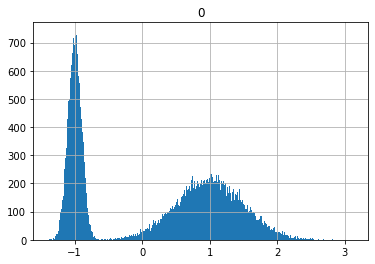

In [149]:
import pandas as pd
pd.DataFrame(test_data_gorusme).hist(bins=1000)

In [150]:
test_sample_gorusme_model = model.sample(100000).detach().numpy()

In [ ]:
test_sample_gorusme_model

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

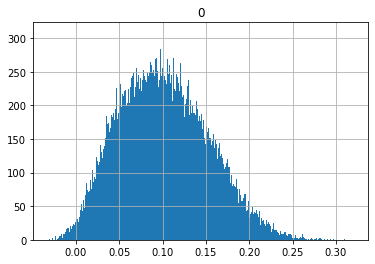

In [151]:
pd.DataFrame(test_sample_gorusme_model).hist(bins=1000)

In [145]:
test_data_gorusme_np = test_data_gorusme.numpy()

In [147]:
type(mixture)

__main__.SimpleGaussianMixture

In [146]:
pdf_vals = mixture.pdf(test_data_gorusme_np)
plt.plot(test_data_gorusme_np, pdf_vals, linewidth=4, label='model density')

plt.axis('off')
plt.ylim(-0.2, 2)
plt.xlim(-2, 3)
plt.xticks([])
plt.yticks([])
plt.legend(framealpha=0)

In [84]:
type(training_data2)

__main__.OneDGMMDataset

In [86]:
type(data_samples)

NameError: name 'data_samples' is not defined

In [13]:
print(torch.cuda.memory_allocated())
print(torch.cuda.max_memory_allocated())
print(torch.cuda.mem_get_info())

0
0
(7509835776, 8589410304)


([], [])

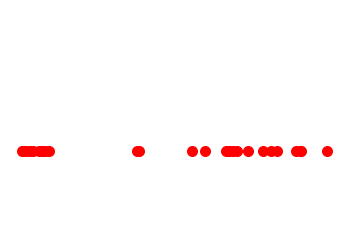

In [7]:
plt.figure()
plt.plot(data_samples, [0] * len(data_samples), 'ro', ms=10, label='data')
plt.axis('off')
plt.ylim(-1, 2)
plt.xticks([])
plt.yticks([])

In [8]:
# Use another set of samples to exemplify samples from the model
data_samples2 = mixture.sample(30)

Implicit Methods

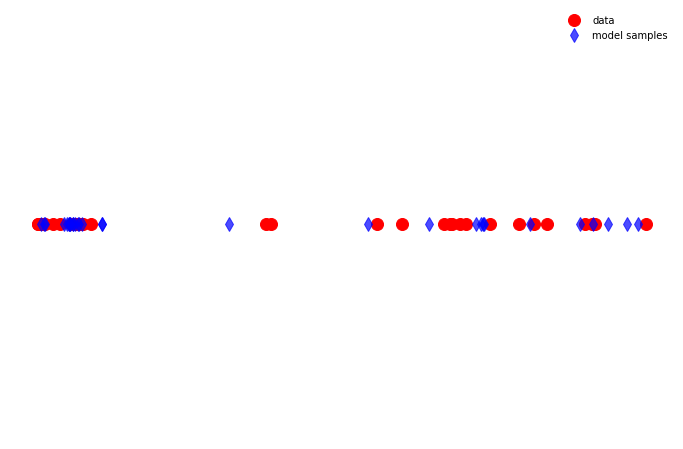

In [10]:
plt.figure(figsize=(12,8))
plt.plot(data_samples, [0] * len(data_samples), 'ro', ms=12, label='data')
plt.plot(data_samples2, [0] * len(data_samples), 'bd', ms=10,  alpha=0.7, label='model samples')
plt.axis('off')
# plt.ylim(-0.2, 2)
# plt.xlim(-2, 3)
plt.xticks([])
plt.yticks([])
plt.legend(framealpha=0.)

In [13]:
def plot_real_vs_fake(prob_distribution, fake_samples):
    length = len(fake_samples)
    real_data_samples = mixture.sample(length)
    plt.plot(real_data_samples, [0] * length, 'ro', ms=12, label='data')
    plt.plot(fake_samples, [0] * length, 'bd', ms=10,  alpha=0.7, label='model samples')
    plt.axis('off')
    # plt.ylim(-0.2, 2)
    # plt.xlim(-2, 3)
    plt.xticks([])
    plt.yticks([])
    plt.legend(framealpha=0.)


In [15]:
test_sample_1 = mixture.sample(30)

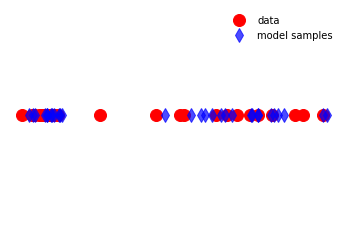

In [16]:
plot_real_vs_fake(prob_distribution = mixture,fake_samples = test_sample_1)

Explicit Methods

In [11]:
plt.figure(figsize=(12,8))
plt.plot(data_samples, [0] * len(data_samples), 'ro', ms=12, label='data')

x_vals = np.linspace(-2., 3., int(1e4))
pdf_vals = mixture.pdf(x_vals)
plt.plot(x_vals, pdf_vals, linewidth=4, label='model density')

plt.axis('off')
plt.ylim(-0.2, 2)
plt.xlim(-2, 3)
plt.xticks([])
plt.yticks([])
plt.legend(framealpha=0)

In [14]:
def plot_real_vs_fake_graph(prob_distribution, fake_samples, x_lim_min, x_lim_max):
    length = len(fake_samples)
    plt.figure(figsize=(12,8))
    plt.plot(fake_samples, [0] * length, 'ro', ms=12, label='data')

    x_vals = np.linspace(x_lim_min, x_lim_max, int(1e3))
    pdf_vals = prob_distribution.pdf(x_vals)
    plt.plot(x_vals, pdf_vals, linewidth=4, label='model density')
    plt.axis('off')
    plt.ylim(-0.2, 2)
    plt.xlim(x_lim_min, x_lim_max)
    plt.xticks([])
    plt.yticks([])
    plt.legend(framealpha=0)

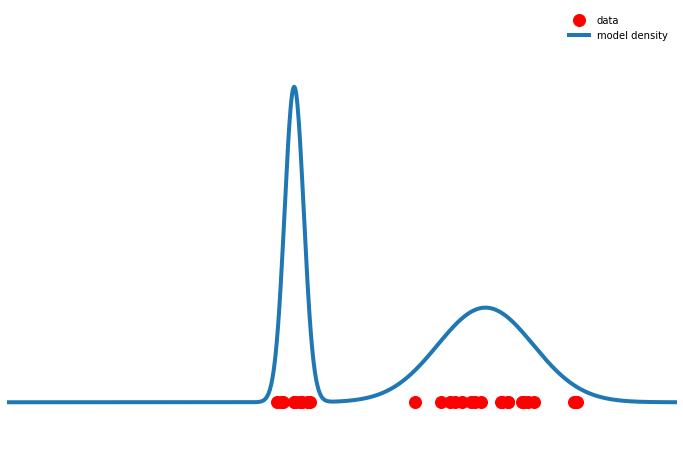

In [18]:
plot_real_vs_fake_graph(prob_distribution = mixture,fake_samples = test_sample_1, x_lim_min = -4, x_lim_max = 3)

In [68]:
class Generator(nn.Module):
    def __init__(self, generator_net, latent_dim):
        super(Generator, self).__init__()
        
        # We need to init the generator neural net.
        self.generator_net = generator_net
        # We also need to know the size of the latents.
        self.latent_dim = latent_dim

    def generate(self, z):
        # Generating for given z is equivalent to applying the neural net.
        return self.generator_net(z)

    def sample(self, batch_size=100):
        # For sampling, we need to sample first latents.
        z = torch.randn(batch_size, self.latent_dim).to(device)
        return self.generate(z)

    def forward(self, z=None):
        if z is None:
            return self.sample()
        else:
            return self.generate(z)

In [69]:
class Discriminator(nn.Module):
    def __init__(self, discriminator_net):
        super(Discriminator, self).__init__()
        # We need to init the discriminator neural net.
        self.discriminator_net = discriminator_net

    def forward(self, x):
        # The forward pass is just about applying the neural net.
        return self.discriminator_net(x)

In [70]:
class GAN(nn.Module):
    def __init__(self, generator, discriminator, EPS=1.e-5):
        super(GAN, self).__init__()

        print('GAN by JT.')
        
        # To put everything together, we need the generator and 
        # the discriminator. NOTE: Both are intanced of classes!
        self.generator = generator
        self.discriminator = discriminator
        
        # For numerical issue, we introduce a small epsilon.
        self.EPS = EPS

    def forward(self, x_real, reduction='avg', mode='discriminator'):
        # The forward pass calculates the adversarial loss.
        # More specifically, either its part for the generator or
        #  the part for the discriminator.
        if mode == 'generator':
            # For the generator, we first sample FAKE data.
            x_fake_gen = self.generator.sample(x_real.shape[0])

            # Then, we calculate outputs of the discriminator for the FAKE data.
            # NOTE: We clamp here for the numerical stability later on.
            d_fake = torch.clamp(self.discriminator(x_fake_gen), self.EPS, 1. - self.EPS)
            
            # The loss for the generator is log(1 - D(G(z))).
            loss = torch.log(1. - d_fake)

        elif mode == 'discriminator':
            # For the discriminator, we first sample FAKE data.
            x_fake_gen = self.generator.sample(x_real.shape[0])

            # Then, we calculate outputs of the discriminator for the FAKE data.
            # NOTE: We clamp for the numerical stability later on.
            d_fake = torch.clamp(self.discriminator(x_fake_gen), self.EPS, 1. - self.EPS)
            
            # Moreover, we calculate outputs of the discriminator for the REAL data.
            # NOTE: We clamp for... the numerical stability (again).
            d_real = torch.clamp(self.discriminator(x_real), self.EPS, 1. - self.EPS)

            # The final loss for the discriminator is log(1 - D(G(z))) + log D(x).
            # NOTE: We take the minus sign because we MAXIMIZE the adversarial loss wrt 
            # discriminator, so we MINIMIZE the negative adversarial loss wrt discriminator.
            loss = -(torch.log(d_real) + torch.log(1. - d_fake))
        
        if reduction == 'sum':
            return loss.sum()
        else:
            return loss.mean()

    def sample(self, batch_size=30):
        return self.generator.sample(batch_size=batch_size)

In [71]:
D = 1   # input dimension
latent_dim = 1 # number of latents
#M = 128  # the number of neurons in scale (s) and translation (t) nets
#The learning rate are searched in {10−2, 10−3, 10−4} for Adam.
#updating critics and generators are searched in {2:1, 3:1, 4:1, 5:1}. We train each setting for 1000000
#iterations and report the best results for each algorithm.
lr_gen = 1e-2 # learning rate
lr_dis = 3e-2 # learning rate
num_epochs = 100 # max. number of epochs


In [46]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [72]:

# First, we initialize the generator and the discriminator
# -generator
generator_net = nn.Sequential(nn.Linear(latent_dim, 7), nn.ELU(),
                              nn.Linear(7, 13), nn.ELU(),
                             nn.Linear(13, 7), nn.ELU(),
                             nn.Linear(7, D))

generator = Generator(generator_net, latent_dim=latent_dim)

# -discriminator
discriminator_net = nn.Sequential(nn.Linear(D, 11), nn.ELU(),
                              nn.Linear(11, 29), nn.ELU(),
                             nn.Linear(29, 11), nn.ELU(),
                             nn.Linear(11, 1), nn.Sigmoid())

discriminator = Discriminator(discriminator_net.to(device))

# Eventually, we initialize the full model
model = GAN(generator=generator.to(device), discriminator=discriminator.to(device)).to(device)

GAN by JT.


In [49]:
model.to(device)

GAN(
  (generator): Generator(
    (generator_net): Sequential(
      (0): Linear(in_features=1, out_features=7, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=7, out_features=13, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=13, out_features=7, bias=True)
      (5): ELU(alpha=1.0)
      (6): Linear(in_features=7, out_features=1, bias=True)
    )
  )
  (discriminator): Discriminator(
    (discriminator_net): Sequential(
      (0): Linear(in_features=1, out_features=11, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=11, out_features=29, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=29, out_features=11, bias=True)
      (5): ELU(alpha=1.0)
      (6): Linear(in_features=11, out_features=1, bias=True)
      (7): Sigmoid()
    )
  )
)

In [50]:
# OPTIMIZER
optimizer_gen = torch.optim.Adam(model.generator.parameters(), lr=lr_gen)
optimizer_dis = torch.optim.Adam(model.discriminator.parameters(), lr=lr_dis)


In [163]:
params = []
for param in model.parameters():
    params.append(param.view(-1))
params = torch.cat(params)
print(params.shape)

torch.Size([936])


In [153]:
optimizer_dis

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.02
    maximize: False
    weight_decay: 0
)

In [31]:
for param_tensor in model.state_dict():
    print(param_tensor)

generator.generator_net.0.weight
generator.generator_net.0.bias
generator.generator_net.2.weight
generator.generator_net.2.bias
generator.generator_net.4.weight
generator.generator_net.4.bias
generator.generator_net.6.weight
generator.generator_net.6.bias
discriminator.discriminator_net.0.weight
discriminator.discriminator_net.0.bias
discriminator.discriminator_net.2.weight
discriminator.discriminator_net.2.bias
discriminator.discriminator_net.4.weight
discriminator.discriminator_net.4.bias
discriminator.discriminator_net.6.weight
discriminator.discriminator_net.6.bias


In [24]:
for param_tensor in model.state_dict():
    test_model_weights = model.state_dict()[param_tensor].numpy()
    print(test_model_weights)


[[ 0.21634746]
 [-0.26725352]
 [ 0.31105816]
 [-0.33536232]
 [ 0.6865417 ]
 [ 0.86850166]
 [-0.57712233]]
[ 0.30865443 -0.52335656 -0.91108096 -0.13842165  0.5150415   0.2625153
  0.7469591 ]
[[ 0.26964602 -0.32625696  0.36825523  0.2740514  -0.23865847 -0.17394798
   0.25424722]
 [ 0.03613946 -0.23242138  0.26632056 -0.22915733 -0.11667001 -0.09763139
  -0.13142829]
 [-0.16691026  0.0860512  -0.08619756 -0.29698524 -0.06590122 -0.08402765
  -0.12399584]
 [ 0.34730032  0.09701204  0.22090235  0.14046344 -0.2664796  -0.24732953
   0.05130544]
 [ 0.30521855 -0.22325133  0.15479395  0.01177886  0.19080427 -0.22608234
   0.08029157]
 [-0.1661434  -0.02818635  0.10645783  0.23724362  0.01338616  0.11310902
   0.36313972]
 [ 0.3692809   0.33995965 -0.24437656  0.30820027 -0.11051646 -0.01583636
  -0.25892556]
 [-0.2656452   0.23818025 -0.12082547 -0.27801368  0.02980304  0.2262477
  -0.23270114]
 [ 0.00460973 -0.15129171  0.27749363 -0.13991205  0.05125859 -0.11436161
   0.15417424]
 [ 0.343

For critics, we use 4-layer MLP with 11, 29, 11 and 1 units. For generators,
we use use 4-layer MLP with 7, 13, 7 and 1 units. For both networks, we use ELU as the non-linear
activation function.
Taken from https://chunliangli.github.io/docs/dltp17gan.pdf

In [66]:
def evaluation(test_loader, name=None, model_best=None, epoch=None, device = 'cpu'):
    # EVALUATION
    if model_best is None:
        # load best performing model
        model_best = torch.load(name + '.model')

    model_best.eval()
    loss_gen = 0.
    loss_dis = 0.
    N = 0.
    for indx_batch, test_batch in enumerate(test_loader):
        #test_batch = test_batch[:,:30,:].to(device)
        test_batch_samples = test_batch[1]
        test_batch_classes = test_batch[0]
        test_batch = test_batch_samples.to(device)
        loss_t_gen = model_best.forward(test_batch, reduction='sum', mode='generator')
        loss_t_dis = model_best.forward(test_batch, reduction='sum', mode='discriminator')
        
        loss_gen = loss_gen + loss_t_gen.item()
        loss_dis = loss_dis + loss_t_dis.item()
        
        N = N + test_batch.shape[0]
    
    loss_gen = loss_gen / N
    loss_dis = loss_dis / N

    if epoch is None:
        print(f'FINAL LOSS: gen={loss_gen}, dis={loss_dis}')
    else:
        print(f'Epoch: {epoch}, val gen={loss_dis}, val dis={loss_dis}')

    return loss_gen, loss_dis


def plot_real_vs_fake(prob_distribution, fake_samples):
    length = len(fake_samples)
    real_data_samples = mixture.sample(length)
    plt.plot(real_data_samples, [0] * length, 'ro', ms=12, label='data')
    plt.plot(fake_samples, [0] * length, 'bd', ms=10,  alpha=0.7, label='model samples')
    plt.axis('off')
    # plt.ylim(-0.2, 2)
    # plt.xlim(-2, 3)
    plt.xticks([])
    plt.yticks([])
    plt.legend(framealpha=0.)
    
def plot_real_vs_fake_graph(prob_distribution, fake_samples, x_lim_min, x_lim_max):
    length = len(fake_samples)
    plt.figure(figsize=(12,8))
    plt.plot(fake_samples, [0] * length, 'ro', ms=12, label='data')

    x_vals = np.linspace(x_lim_min, x_lim_max, int(1e3))
    pdf_vals = prob_distribution.pdf(x_vals)
    plt.plot(x_vals, pdf_vals, linewidth=4, label='model density')
    plt.axis('off')
    plt.ylim(-0.2, 2)
    plt.xlim(x_lim_min, x_lim_max)
    plt.xticks([])
    plt.yticks([])
    plt.legend(framealpha=0)
   


In [67]:
manual_train_samples = mixture.sample(30)

In [68]:
manual_train_samples = manual_train_samples.float()

In [158]:
manual_train_samples_np = manual_train_samples.numpy()

In [69]:
model.state_dict()

OrderedDict([('generator.generator_net.0.weight',
              tensor([[-0.1208],
                      [ 0.7285],
                      [ 0.0985],
                      [-0.4948],
                      [-0.3328],
                      [-0.8527],
                      [ 0.3272]], device='cuda:0')),
             ('generator.generator_net.0.bias',
              tensor([-0.8367,  0.3882,  0.0652,  0.2044, -0.6883,  0.2735,  0.4861],
                     device='cuda:0')),
             ('generator.generator_net.2.weight',
              tensor([[ 0.3313, -0.2216, -0.1185, -0.0578,  0.2865, -0.1278,  0.0664],
                      [ 0.6170, -0.6959, -0.2379, -0.2629,  0.3485, -0.3019, -0.4727],
                      [ 0.4677, -0.2583, -0.3744, -0.1261,  0.6866, -0.1086, -0.2615],
                      [-0.3943,  0.1277,  0.2019,  0.4249, -0.0664,  0.2772,  0.0729],
                      [ 0.2047,  0.1333, -0.0981, -0.1286,  0.2040, -0.4331, -0.2487],
                      [-0.4418, -0.1865,

In [70]:
manual_train_samples_cuda = manual_train_samples.to(device)

In [71]:
loss_dis = model(manual_train_samples_cuda, mode='discriminator')           
optimizer_dis.zero_grad()
optimizer_gen.zero_grad()
loss_dis.backward(retain_graph=True)
optimizer_dis.step()
loss_gen = model(manual_train_samples_cuda, mode='generator')  
optimizer_dis.zero_grad()
optimizer_gen.zero_grad()
loss_gen.backward(retain_graph=True)
optimizer_gen.step()

In [212]:
optimizer_gen

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [213]:
print(model)

GAN(
  (generator): Generator(
    (generator_net): Sequential(
      (0): Linear(in_features=1, out_features=7, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=7, out_features=13, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=13, out_features=7, bias=True)
      (5): ELU(alpha=1.0)
      (6): Linear(in_features=7, out_features=1, bias=True)
    )
  )
  (discriminator): Discriminator(
    (discriminator_net): Sequential(
      (0): Linear(in_features=1, out_features=11, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=11, out_features=29, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=29, out_features=11, bias=True)
      (5): ELU(alpha=1.0)
      (6): Linear(in_features=11, out_features=1, bias=True)
      (7): Sigmoid()
    )
  )
)


In [166]:
model(manuel_train_samples, mode='generator')

tensor(-0.7265, grad_fn=<MeanBackward0>)

In [106]:
generator(manuel_train_samples)

tensor([[0.3441],
        [0.3416],
        [0.4917],
        ...,
        [0.3373],
        [0.3528],
        [0.3679]], grad_fn=<AddmmBackward0>)

In [20]:
generator()

tensor([[-0.1867],
        [-0.1933],
        [-0.1982],
        [-0.1989],
        [-0.1870],
        [-0.1936],
        [-0.1956],
        [-0.1982],
        [-0.1981],
        [-0.1919],
        [-0.1955],
        [-0.1938],
        [-0.1894],
        [-0.1914],
        [-0.1956],
        [-0.1968],
        [-0.1951],
        [-0.1907],
        [-0.1886],
        [-0.1959],
        [-0.1988],
        [-0.1973],
        [-0.1876],
        [-0.1781],
        [-0.1890],
        [-0.1867],
        [-0.1976],
        [-0.1930],
        [-0.1905],
        [-0.1835]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
d

In [88]:
optimizer_dis

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.02
    maximize: False
    weight_decay: 0
)

In [88]:
optimizer_gen.step()
optimizer_dis.step()

In [94]:
print(loss_gen)
print(loss_dis)

tensor(-6.6875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.2482, device='cuda:0', grad_fn=<MeanBackward0>)


In [72]:
model.state_dict()

OrderedDict([('generator.generator_net.0.weight',
              tensor([[-0.1208],
                      [ 0.7285],
                      [ 0.0985],
                      [-0.4948],
                      [-0.3328],
                      [-0.8527],
                      [ 0.3272]], device='cuda:0')),
             ('generator.generator_net.0.bias',
              tensor([-0.8367,  0.3882,  0.0652,  0.2044, -0.6883,  0.2735,  0.4861],
                     device='cuda:0')),
             ('generator.generator_net.2.weight',
              tensor([[ 0.3313, -0.2216, -0.1185, -0.0578,  0.2865, -0.1278,  0.0664],
                      [ 0.6170, -0.6959, -0.2379, -0.2629,  0.3485, -0.3019, -0.4727],
                      [ 0.4677, -0.2583, -0.3744, -0.1261,  0.6866, -0.1086, -0.2615],
                      [-0.3943,  0.1277,  0.2019,  0.4249, -0.0664,  0.2772,  0.0729],
                      [ 0.2047,  0.1333, -0.0981, -0.1286,  0.2040, -0.4331, -0.2487],
                      [-0.4418, -0.1865,

In [73]:
def training(name, num_epochs, model, optimizer_gen, optimizer_dis, training_loader, val_loader, device = 'cpu'):
    model = model.to(device)
    gen_val = []
    dis_val = []
    best_loss = 1000.
    patience = 0
    model_weights = []
    # Main loop
    for e in range(num_epochs):
        # TRAINING
        model.train()
        for indx_batch, batch in enumerate(training_loader):
            #batch = batch[:,31:61,:].to(device)
            batch_samples = batch[1]
            batch_classes = batch[0]
            batch = batch_samples.to(device)
            # -Discriminator
            loss_dis = model(batch, mode='discriminator')         
            optimizer_dis.zero_grad()
            optimizer_gen.zero_grad()
            loss_dis.backward(retain_graph=True)
            optimizer_dis.step()
            
            # -Generator
            loss_gen = model(batch, mode='generator')
            optimizer_dis.zero_grad()
            optimizer_gen.zero_grad()
            loss_gen.backward(retain_graph=True)
            optimizer_gen.step()
        #Save the current state of the model weights
        model_weights.append(model.state_dict())
        # Validation
        loss_val_gen, loss_val_dis = evaluation(val_loader, model_best=model, epoch=e, device = device)
        gen_val.append(loss_val_gen)  # save for plotting
        dis_val.append(loss_val_dis)  # save for plotting
        
        torch.save(model.state_dict(), name + 'epoch_' +str(e) + '.model')

    gen_val = np.asarray(gen_val)
    dis_val = np.asarray(dis_val)
    return gen_val, dis_val, model_weights

In [53]:
result_dir='C:/Users/aligursu/'
name='trained_models/1DGMMGAN_v2'

In [55]:
model_weights

NameError: name 'model_weights' is not defined

In [56]:
print(f"Using {device} device")
if( device == "cuda"):
    generator.cuda()
    discriminator.cuda()
    model.cuda()

Using cuda device


In [57]:
num_epochs = 5# max. number of epochs , currently trained for 1800 epochs

In [77]:
model = model.double()

In [78]:
# Training procedure
gen_val, dis_val, model_weights = training(name=result_dir + name, 
                            num_epochs=num_epochs, 
                            model=model, 
                            optimizer_gen=optimizer_gen,
                            optimizer_dis=optimizer_dis,
                            training_loader=train_dataloader,
                            val_loader=validation_dataloader,
                            device = device
                            )

RuntimeError: expected scalar type Double but found Float

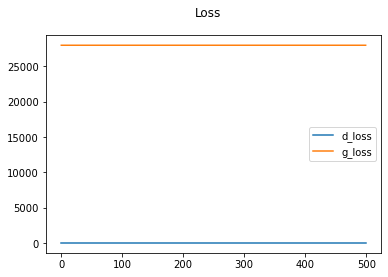

In [253]:
plt.suptitle('Loss')
plt.plot(gen_val, label='d_loss')
plt.plot(dis_val, label='g_loss')
plt.legend()
plt.show()

In [81]:
torch.load('C:/Users/aligursu/train_gmm_data/test_gmm_428.pt')

tensor([[ 1.8688],
        [ 1.1353],
        [ 1.2087],
        ...,
        [-1.0279],
        [-1.1697],
        [ 0.3742]], dtype=torch.float64)

tensor([[0.1410],
        [0.0599],
        [0.1776],
        [0.0629],
        [0.1273],
        [0.0979],
        [0.0399],
        [0.0805],
        [0.1122],
        [0.1262]], grad_fn=<AddmmBackward0>)

In [57]:
test_sample_1 = model.sample(30).cpu().detach().numpy()

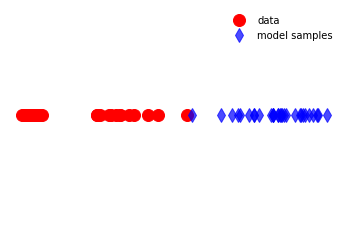

In [58]:
plot_real_vs_fake(prob_distribution = mixture,fake_samples = test_sample_1)

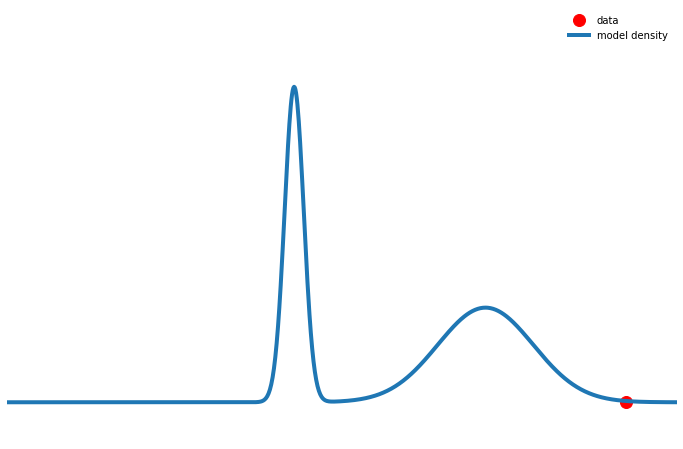

In [59]:
plot_real_vs_fake_graph(prob_distribution = mixture,fake_samples = test_sample_1, x_lim_min = -4, x_lim_max = 3)

In [52]:
model_weights[33]

OrderedDict([('generator.generator_net.0.weight',
              tensor([[-0.1208],
                      [ 0.7285],
                      [ 0.0985],
                      [-0.4948],
                      [-0.3328],
                      [-0.8527],
                      [ 0.3272]], device='cuda:0')),
             ('generator.generator_net.0.bias',
              tensor([-0.8367,  0.3882,  0.0652,  0.2044, -0.6883,  0.2735,  0.4861],
                     device='cuda:0')),
             ('generator.generator_net.2.weight',
              tensor([[ 0.3313, -0.2216, -0.1185, -0.0578,  0.2865, -0.1278,  0.0664],
                      [ 0.6170, -0.6959, -0.2379, -0.2629,  0.3485, -0.3019, -0.4727],
                      [ 0.4677, -0.2583, -0.3744, -0.1261,  0.6866, -0.1086, -0.2615],
                      [-0.3943,  0.1277,  0.2019,  0.4249, -0.0664,  0.2772,  0.0729],
                      [ 0.2047,  0.1333, -0.0981, -0.1286,  0.2040, -0.4331, -0.2487],
                      [-0.4418, -0.1865,

In [75]:
model_weights[0]

OrderedDict([('generator.generator_net.0.weight',
              tensor([[-0.1208],
                      [ 0.7285],
                      [ 0.0985],
                      [-0.4948],
                      [-0.3328],
                      [-0.8527],
                      [ 0.3272]], device='cuda:0')),
             ('generator.generator_net.0.bias',
              tensor([-0.8367,  0.3882,  0.0652,  0.2044, -0.6883,  0.2735,  0.4861],
                     device='cuda:0')),
             ('generator.generator_net.2.weight',
              tensor([[ 0.3313, -0.2216, -0.1185, -0.0578,  0.2865, -0.1278,  0.0664],
                      [ 0.6170, -0.6959, -0.2379, -0.2629,  0.3485, -0.3019, -0.4727],
                      [ 0.4677, -0.2583, -0.3744, -0.1261,  0.6866, -0.1086, -0.2615],
                      [-0.3943,  0.1277,  0.2019,  0.4249, -0.0664,  0.2772,  0.0729],
                      [ 0.2047,  0.1333, -0.0981, -0.1286,  0.2040, -0.4331, -0.2487],
                      [-0.4418, -0.1865,

In [69]:
print(type(model_weights[0]))
print(type(model.state_dict()))

<class 'collections.OrderedDict'>
<class 'collections.OrderedDict'>


In [70]:
set_a = set(model.state_dict().items()) 
set_b = set(model_weights[0].items())
set_a - set_b 

{('discriminator.discriminator_net.0.bias',
  tensor([-0.7505,  0.1591, -0.7008, -4.7531,  1.1346, -2.6686, -2.7987, -4.0887,
           1.0909, -0.6071, -1.0050], device='cuda:0')),
 ('discriminator.discriminator_net.0.weight',
  tensor([[ 0.4009],
          [-0.3664],
          [ 0.5335],
          [ 0.1315],
          [-0.0029],
          [-0.0766],
          [ 0.0555],
          [ 0.0265],
          [-0.5472],
          [ 0.9304],
          [ 0.4599]], device='cuda:0')),
 ('discriminator.discriminator_net.2.bias',
  tensor([-1.7512, -3.4074, -3.9346, -1.8014, -4.1451, -1.5602, -3.8932,  3.6074,
          -1.7873, -3.1200, -4.4942, -3.8015, -3.8321, -2.1452, -3.1350,  0.8441,
          -3.4851, -3.2863, -3.6994,  2.1133,  2.3218, -3.8710, -2.4874, -2.7708,
           0.8612,  0.1300, -1.9924, -3.6380, -2.7481], device='cuda:0')),
 ('discriminator.discriminator_net.2.weight',
  tensor([[-0.0372,  0.1447, -0.1086,  1.9238,  2.2021,  0.8987,  0.0661,  1.8129,
           -0.2830, -0.190

In [48]:
model.state_dict().items()

odict_items([('generator.generator_net.0.weight', tensor([[-0.3885],
        [ 1.0284],
        [-0.0598],
        [-0.7538],
        [-0.6120],
        [-1.1533],
        [ 0.6075]], device='cuda:0')), ('generator.generator_net.0.bias', tensor([-0.5251,  0.0806,  0.3751,  0.5143, -0.3757,  0.5844,  0.1767],
       device='cuda:0')), ('generator.generator_net.2.weight', tensor([[ 0.0420, -0.0825,  0.1727,  0.2472,  0.0050,  0.1806,  0.3185],
        [ 0.3292, -0.5688,  0.0492,  0.0349,  0.0698, -0.0011, -0.2251],
        [ 0.3351, -0.2474, -0.2456,  0.0349,  0.5771,  0.0646, -0.1975],
        [-0.1592,  0.0698, -0.0287,  0.1731,  0.1488,  0.0181, -0.0903],
        [-0.0771,  0.2505,  0.1808,  0.1601, -0.0669, -0.1411, -0.0123],
        [-0.1514, -0.3230, -0.0239,  0.2330,  0.3324,  0.0575,  0.1521],
        [-0.1677, -0.1201,  0.2194, -0.3009, -0.2288, -0.5217, -0.2428],
        [ 0.1997, -0.5505, -0.1854,  0.5139,  0.4269,  0.3518, -0.2373],
        [ 0.1230,  0.2713,  0.1778, -0.2034

In [64]:
for indx_batch, test_batch in enumerate(train_dataloader):
    print(test_batch[0])

tensor([[1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
         1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
         0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
         0, 1, 1, 1]])
tensor([[1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
         0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
         0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
         1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
         0, 1, 1, 1]])
tensor([[1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
         0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
         1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
         1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 

tensor([[1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
         1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
         1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
         1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
         0, 1, 1, 0]])
tensor([[0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
         1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
         1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
         1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
         1, 1, 1, 1]])
tensor([[1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
         1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
         0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
         1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 

In [60]:
test_sample_1 = model.sample(100000).cpu().detach().numpy()

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

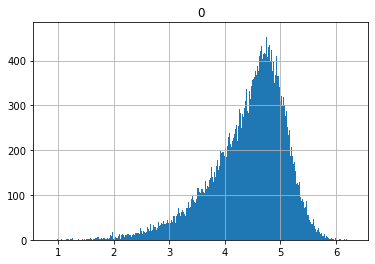

In [61]:
pd.DataFrame(test_sample_1).hist(bins=1000)

We compare (1) g✓(z) with
the true transformation function and (2) the empirical distribution from 10, 000 samples with PX